# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# import sql library
from sqlalchemy import create_engine

# import nltk libraries
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# import sci-kit learn libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


# import library to save trained model
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abdis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# load data from database
database_filepath = './data/DisasterResponse.db'
engine = create_engine('sqlite:///{}'.format(database_filepath))
table_name = os.path.basename(database_filepath).split('.')[0]
df = pd.read_sql_table(table_name, engine)
X = df['message']
Y = df.iloc[:,4:]

In [3]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [4]:
def tokenize(text):
    
    # check if there are urls within the text
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex,text)
    for url in detected_urls:
        text = text.replace(url,"urlplaceholder")
    
    # remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]"," ",text)
    
    # tokenize the text
    tokens = word_tokenize(text)
    
    # remove stop words
    tokens = [tok for tok in tokens if tok not in stopwords.words("english")]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state = 42)

In [7]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001343E160700>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier()))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

metrics sorted:
1. Precision: Precision explains how many of the correctly predicted cases actually turned out to be positive. Precision is useful in the cases where False Positive is a higher concern than False Negatives. The importance of Precision is in music or video recommendation systems, e-commerce websites, etc. where wrong results could lead to customer churn and this could be harmful to the business.
2. Recall (Sensitivity): Recall explains how many of the actual positive cases we were able to predict correctly with our model. It is a useful metric in cases where False Negative is of higher concern than False Positive. It is important in medical cases where it doesn’t matter whether we raise a false alarm but the actual positive cases should not go undetected!
3. F1 Score: It gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.
4. AUC-ROC: The Receiver Operator Characteristic (ROC) is a probability curve that plots the TPR(True Positive Rate) against the FPR(False Positive Rate) at various threshold values and separates the ‘signal’ from the ‘noise’.

#### Test model on training set

In [8]:
# predict on the train set
Y_train_pred = pipeline.predict(X_train)

# classification report on train set
print(classification_report(Y_train.values, Y_train_pred, target_names=Y.columns.values))

# Model accuracy score on train set
Y_train_accuracy = (Y_train_pred == Y_train).mean()
print(Y_train_accuracy)

                        precision    recall  f1-score   support

               related       1.00      1.00      1.00     15103
               request       1.00      0.99      1.00      3504
                 offer       1.00      0.96      0.98       226
           aid_related       1.00      1.00      1.00      8331
          medical_help       1.00      0.99      1.00      1690
      medical_products       1.00      0.99      0.99      1110
     search_and_rescue       1.00      0.99      0.99       706
              security       1.00      0.97      0.99       496
              military       0.99      0.99      0.99       801
           child_alone       0.99      0.96      0.97       141
                 water       1.00      0.99      1.00      1395
                  food       1.00      1.00      1.00      2319
               shelter       1.00      1.00      1.00      1874
              clothing       1.00      0.98      0.99       448
                 money       1.00      

#### Test model on test set

In [9]:
# predict on the test set
Y_test_pred = pipeline.predict(X_test)

# classification report on test set
print(classification_report(Y_test.values, Y_test_pred, target_names=Y.columns.values))

# Model accuracy score on test set
Y_test_accuracy = (Y_test_pred == Y_test).mean()
print(Y_test_accuracy)

                        precision    recall  f1-score   support

               related       0.83      0.94      0.88      4991
               request       0.80      0.48      0.60      1158
                 offer       0.30      0.16      0.21        80
           aid_related       0.72      0.69      0.71      2717
          medical_help       0.56      0.15      0.23       582
      medical_products       0.52      0.11      0.18       391
     search_and_rescue       0.47      0.12      0.19       206
              security       0.26      0.09      0.13       163
              military       0.48      0.16      0.24       247
           child_alone       0.24      0.26      0.24        47
                 water       0.77      0.41      0.53       465
                  food       0.80      0.63      0.70       792
               shelter       0.75      0.43      0.55       628
              clothing       0.50      0.21      0.30       145
                 money       0.48      

> when predict on test set, model has lower precision accuracy recall. This indicates overfitting, the precision ranges from 0.3-0.8.
we may need to try other way improving the model.

### 6. Improve your model
Use grid search to find better parameters. 

In [10]:
pipeline.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001343E160700>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=RandomForestClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001343E160700>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,


Advise to have a gridsearch that runs in adequate time: reduce complexity by using 2-3 parameters with 2-3 values in each

In [13]:
# specify parameters for grid search
# Reduce cv=2 instead of default cv=5 if needed 
# Use verbose=2 or 3 to know that the process is running

pipe_params = {'clf__estimator__n_estimators':[100,200],
              'clf__estimator__min_samples_split': [2,3]}

# create grid search object
grid_pipe = GridSearchCV(pipeline, param_grid=pipe_params, verbose=3)

It takes a very long time to fit the cv into the train set

In [12]:
grid_pipe.fit(X_train,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100;, score=0.262 total time= 9.6min
[CV 2/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100;, score=0.258 total time=10.0min
[CV 3/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100;, score=0.272 total time=12.0min
[CV 4/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100;, score=0.267 total time=11.4min
[CV 5/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=100;, score=0.266 total time= 9.7min
[CV 1/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200;, score=0.267 total time=16.4min
[CV 2/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200;, score=0.254 total time=17.2min
[CV 3/5] END clf__estimator__min_samples_split=2, clf__estimator__n_estimators=200;, score=0.273 total time=16.9min
[CV 4/5] END

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000001343E160700>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=RandomForestClassifier()))]),
             param_grid={'clf__estimator__min_samples_split': [2, 3],
                         'clf__estimator__n_estimators': [100, 200]},
             verbose=3)

In [13]:
grid_pipe.best_params_

{'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 200}

In [14]:
grid_pipe.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200)))])

In [15]:
grid_pipe.best_score_

0.2675215247046213

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

The best parameters and estimators is {'clf__estimator__min_samples_split': 2, 'clf__estimator__n_estimators': 200}, it doesn't seem to have a big improvement with parameters tuning, so we keep the original setting as it is.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### Other machine learning algorithms

> 1. AdaBoostClassifier
> 2. SVM

1. AdaBoostClassifier

In [16]:
ABC_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])

In [17]:
ABC_pipe.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=AdaBoostClassifier()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=AdaBoostClassifier()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf_

In [18]:
ABC_pipe.fit(X_train,Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(estimator=AdaBoostClassifier()))])

In [19]:
ABC_pred = ABC_pipe.predict(X_test)

In [20]:
ABC_accuracy = (ABC_pred == Y_test).mean()

2. SVM

In [21]:
SVC_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(SVC()))
])

In [22]:
SVC_pipe.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
  ('tfidf', TfidfTransformer()),
  ('clf', MultiOutputClassifier(estimator=SVC()))],
 'verbose': False,
 'vect': CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=SVC()),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': <function __main__.tokenize(text)>,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'clf__estima

In [23]:
SVC_pipe.fit(X_train,Y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
                ('tfidf', TfidfTransformer()),
                ('clf', MultiOutputClassifier(estimator=SVC()))])

In [24]:
SVC_pred = SVC_pipe.predict(X_test)

In [25]:
SVC_accuracy = (SVC_pred == Y_test).mean()

note:

### How to avoid data leakage
Below are some tips on avoiding data leakage:

- Always split the data into train and test subsets first, particularly before any preprocessing steps.

- Never include test data when using the fit and fit_transform methods. Using all the data, e.g., fit(X), can result in overly optimistic scores.

- Conversely, the transform method should be used on both train and test subsets as the same preprocessing should be applied to all the data. This can be achieved by using `fit_transform` on the train subset and `transform` on the test subset.

- The scikit-learn `pipeline` is a great way to prevent data leakage as it ensures that the appropriate method is performed on the correct data subset. The pipeline is ideal for use in cross-validation and hyper-parameter tuning functions.

### Accuracy comparison

In [26]:
# concatenate accuracry scores
accuracy_df = pd.concat([Y_test_accuracy, ABC_accuracy, SVC_accuracy],axis=1)
accuracy_df.columns=['RandomForest','AdaBoost','SupportVectorMachine']

print('Models Accuracy Score Comparison')
accuracy_df

Models Accuracy Score Comparison


,RandomForest,AdaBoost,SupportVectorMachine
related,0.813854,0.786695,0.820415
request,0.889381,0.881904,0.898840
offer,0.984742,0.988099,0.987794
aid_related,0.768996,0.745957,0.775404
medical_help,0.915471,0.917608,0.917302
medical_products,0.939884,0.949649,0.945987
search_and_rescue,0.968569,0.971620,0.969332
security,0.971163,0.972078,0.974977
military,0.960330,0.964144,0.962771
child_alone,0.990082,0.992524,0.992829


In [27]:
to_graph = accuracy_df.to_dict()

Text(0, 0.5, 'Accuracy rate')

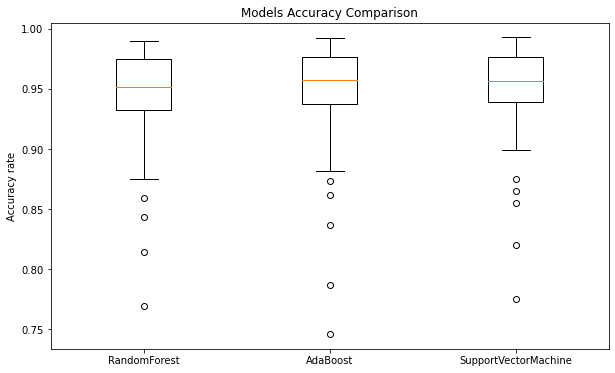

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
ax.boxplot(accuracy_df.values)
ax.set_xticklabels(['RandomForest','AdaBoost','SupportVectorMachine'])

plt.title('Models Accuracy Comparison')
plt.ylabel('Accuracy rate')

Regardless the implement of GridSearch, Support Vector Machine works slightly better than the other two model from the point of accuracy, since the overall accuracy of the model is highest among these three models. However, the Support Vector Machine took too long time than the other two model. So, in this case, let's use Adaboost as illustration, as it is better than Random Forest. 

### Use Custom Transformer 

1. Create a custom estimator that identify the buzzwords relates to Disaster
2. Apply the feature union in above pipleline using rfc as the estimator

In [29]:
class DisasterWordExtractor(BaseEstimator, TransformerMixin):

    def disaster_words(self, text):
        """
        INPUT:
        text(str) - raw text data
        
        OUTPUT:
        bool(boolean object) - 1 or 0
        """
        # list of words that are commonly used during a disaster event
        disaster_words = ['food','hunger','hungry','starving','water','drink','eat','thirsty',
                 'need','hospital','medicine','medical','ill','pain','disease','injured','falling',
                 'wound','blood','dying','death','dead','aid','help','assistance','cloth','cold','wet','shelter',
                 'hurricane','earthquake','flood','whirlpool','live','alive','child','people','shortage','blocked',
                 'trap','rob','gas','pregnant','baby','cry','fire','blizard','freezing','blackout','drought',
                 'hailstorm','heat','pressure','lightning','tornado','tsunami']
        
        # lemmatize the buzzwords
        lemmatized_words = [WordNetLemmatizer().lemmatize(w, pos='v') for w in disaster_words]
        # Get the stem words of each word in lemmatized_words 
        stem_disaster_words = [PorterStemmer().stem(w) for w in lemmatized_words]
        
        # tokenize the input text
        clean_tokens = tokenize(text)
        for token in clean_tokens:
            if token in stem_disaster_words:
                return 1
        return 0
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_disaster_words = pd.Series(X).apply(self.disaster_words)
        return pd.DataFrame(X_disaster_words)

In [30]:
buzzword_pipe = Pipeline([
    ('features',FeatureUnion([
        ('text_pipeline',Pipeline([
            ('vect',CountVectorizer(tokenizer=tokenize)),
            ('tfidf',TfidfTransformer())
        ])),
        ('disaster_words',DisasterWordExtractor())
    ])),
    ('clf',MultiOutputClassifier(AdaBoostClassifier()))
])

In [31]:
buzzword_pipe.get_params()

{'memory': None,
 'steps': [('features',
   FeatureUnion(transformer_list=[('text_pipeline',
                                   Pipeline(steps=[('vect',
                                                    CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
                                                   ('tfidf',
                                                    TfidfTransformer())])),
                                  ('disaster_words', DisasterWordExtractor())])),
  ('clf', MultiOutputClassifier(estimator=AdaBoostClassifier()))],
 'verbose': False,
 'features': FeatureUnion(transformer_list=[('text_pipeline',
                                 Pipeline(steps=[('vect',
                                                  CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
                                                 ('tfidf',
                                                  TfidfTransformer())])),
                                ('disaster_wo

In [32]:
buzzword_pipe.fit(X_train,Y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x000001CBE8A4A700>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('disaster_words',
                                                 DisasterWordExtractor())])),
                ('clf', MultiOutputClassifier(estimator=AdaBoostClassifier()))])

In [33]:
buzzword_pred= buzzword_pipe.predict(X_test)

In [34]:
# classification report on test set
print('With Disaster Word Extractor Test Scores')
print(classification_report(Y_test.values, buzzword_pred, target_names=Y.columns.values))

With Disaster Word Extractor Test Scores
                        precision    recall  f1-score   support

               related       0.80      0.96      0.87      4991
               request       0.78      0.47      0.58      1158
                 offer       0.75      0.04      0.07        80
           aid_related       0.73      0.62      0.67      2717
          medical_help       0.59      0.24      0.34       582
      medical_products       0.68      0.30      0.41       391
     search_and_rescue       0.69      0.17      0.28       206
              security       0.08      0.01      0.02       163
              military       0.58      0.26      0.35       247
           child_alone       0.58      0.15      0.24        47
                 water       0.73      0.57      0.64       465
                  food       0.80      0.69      0.74       792
               shelter       0.77      0.52      0.62       628
              clothing       0.67      0.34      0.45       14

C:\Users\abdis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\abdis\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# accuracy score on test set
print('With Disaster Word Extractor Accuracy')
buzzword_accuracy = (buzzword_pred == Y_test).mean()
buzzword_accuracy.mean()

With Disaster Word Extractor Accuracy


0.9410834774353235

In [36]:
# concatenate accuracry scores
accuracy_2_df = pd.concat([ABC_accuracy, buzzword_accuracy],axis=1)
accuracy_2_df.columns=['AdaBoost','AdaBoost+buzzwords']

print('Models with Buzzwords Feature Accuracy Score Comparison')
accuracy_2_df

Models with Buzzwords Feature Accuracy Score Comparison


,AdaBoost,AdaBoost+buzzwords
related,0.786695,0.788068
request,0.881904,0.881904
offer,0.988099,0.988099
aid_related,0.745957,0.744431
medical_help,0.917608,0.917913
medical_products,0.949649,0.949649
search_and_rescue,0.971620,0.971620
security,0.972078,0.972078
military,0.964144,0.965060
child_alone,0.992524,0.993134


In [37]:
to_graph_2 = accuracy_2_df.to_dict()

Text(0, 0.5, 'Accuracy rate')

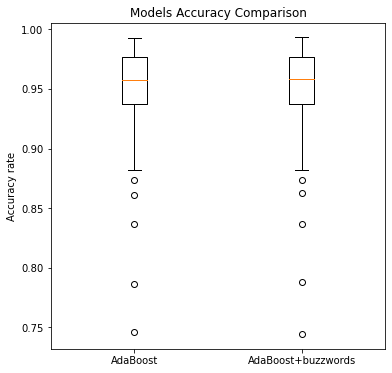

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(accuracy_2_df.values)
ax.set_xticklabels(['AdaBoost','AdaBoost+buzzwords'])

plt.title('Models Accuracy Comparison')
plt.ylabel('Accuracy rate')

I'm going to use Adaboost with Feature union WITHOUT gridsearch for the final ML model

### 9. Export your model as a pickle file

In [39]:
import pickle

In [40]:
# save the model to disk
pickle.dump(buzzword_pipe, open('classifier.pkl','wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.